In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import regularizers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

### Create 'gan_samples' folder which will contain all images samples collected during the training
### e.g 1000.png => batch of images samples generated by the generator after 1000 iterations

In [2]:
if not os.path.exists('gan_samples/'):
    os.makedirs('gan_samples/')

### Parameters constants

In [3]:
seed          = 2019
batch_size    = 64
iterations    = 100000
lr            = 1e-4
Z_dim         = 100

### We want the results to be reproducible :-) 

In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

### Load mnist dataset

In [5]:
(x_train, _), (_, _) = datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784).astype('float32') / 255

### (1) The discriminator network
 It's just a simple MLP network with 1 hidden layers
It returns the probability that the input image is a real image

In [6]:
class Discriminator(tf.keras.layers.Layer):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.linear_1 = layers.Dense(128)
        self.linear_2 = layers.Dense(1)
            
    def call(self, x):
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, 0.2)
        x = self.linear_2(x)
        x = tf.nn.sigmoid(x)        
        return x

### (2) The generator network
It's just a simple MLP network with 1 hidden layers
It return the generated image that is hopefully similar to the samples in MNIST dataset after training.

In [7]:
class Generator(tf.keras.layers.Layer):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear_1 = layers.Dense(128)
        self.linear_2 = layers.Dense(784)
            
    def call(self, x):
        x = self.linear_1(x)
        x = tf.nn.relu(x)
        x = tf.nn.dropout(x, 0.2)
        x = self.linear_2(x)
        x = tf.nn.sigmoid(x)        
        return x

### Function that used to generate a batch of noise samples to feed to the generator

In [8]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

### During the GAN training we want to observe the GAN quality

In [9]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

### Models and optimizer instantiation

In [10]:
generator     = Generator()
discriminator = Discriminator()
optimizer = tf.optimizers.Adam(lr)

### Here we go ;-)
### See the comments


In [11]:
D_losses = []
G_losses = []

# ------------------------------------------------------------------------------------
# Start of the training loop
# ------------------------------------------------------------------------------------
for it in range(iterations):
    
    # ------------------------------------------------------------------------------------
    # Every 1000 iteration we save some samples from the generator to show how it performs
    # during the training.
    # ------------------------------------------------------------------------------------
    if it % 1000 == 0:
        samples = generator(sample_Z(16, Z_dim))
        
        fig = plot(samples.numpy())
        plt.savefig('gan_samples/{}.png'.format(str(it).zfill(3)), bbox_inches='tight')
        plt.close(fig)
   
    # ------------------------------------------------------------------------------------
    # Sample batch of the training examples
    # ------------------------------------------------------------------------------------    
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    Real_sample = x_train[idx]
    
    # ====================================================================================
    #
    #
    # The first step is to train the discriminator
    # --------------------------------------------
    #    
    #
    # Note: Please don't forget that the output of the discriminator is the probability of
    #       the given input image is real image (drawn from the training set).
    #
    #
    #
    # We want to train the discriminator to
    #
    # 1- Maximize the probability of assigning the correct label to the training examples " Max. log(D(x)) )  "
    # 2- Minimize the probability of assigning the correct label to the fake examples     " Min. log(D(G(Z))) "
    #
    #
    # We could do that by maximize 
    
    #                               log(D(x))+(1-log(D(G(Z))))
    #
    # The negative sign in the front of D_loss below because the tensorflow optimizer minimize
    # the objective function and we want to maximize the objective function
    # Here we take the gradient of the objective function with respect to the 
    # discriminator parameters
    # ------------------------------------------------------------------------------------        
    with tf.GradientTape() as tape:  
        Z           = sample_Z(batch_size, Z_dim)
        Fake_sample = generator(Z)
        D_real_prob = discriminator(Real_sample)
        D_fake_prob = discriminator(Fake_sample)
        D_loss      = -tf.reduce_mean(tf.math.log(D_real_prob) + tf.math.log(1. - D_fake_prob))

        gradients = tape.gradient(D_loss, discriminator.trainable_weights)
    optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

    # ====================================================================================
    #
    # The second step is to train the generator
    # -----------------------------------------
    #
    #
    # The generator tries to fool the discriminator and make the discriminator to predict 
    # the fake image G(Z) as a real image , in other words try to 
    # 
    #                              maximize log(D(G(Z)))
    #
    #
    # Here we take the gradient of the objective function with respect to the 
    # generator parameters
    # ------------------------------------------------------------------------------------        
    with tf.GradientTape() as tape:        
        Z           = sample_Z(batch_size, Z_dim)
        Fake_sample = generator(Z)
        D_fake_prob = discriminator(Fake_sample)
        
        G_loss   = -tf.reduce_mean(tf.math.log(D_fake_prob))
                
        gradients = tape.gradient(G_loss, generator.trainable_weights)
    optimizer.apply_gradients(zip(gradients, generator.trainable_weights))
    
    # ------------------------------------------------------------------------------------
    # Evaluate the training process by printing both of the discriminator and the 
    # generator losses every 1000 iterations
    # ------------------------------------------------------------------------------------
    if it % 1000 == 0:
        print('Iter: {}     D_loss: {:.4f}     G_loss: {:.4f}'.format(it, D_loss, G_loss))

    # ------------------------------------------------------------------------------------
    # Save the current iteration losses to plot them later at the end of training session
    # ------------------------------------------------------------------------------------
    D_losses.append(D_loss)
    G_losses.append(G_loss)
        

Iter: 0     D_loss: 1.7229     G_loss: 0.4648
Iter: 1000     D_loss: 0.3494     G_loss: 2.1275
Iter: 2000     D_loss: 0.2425     G_loss: 1.9372
Iter: 3000     D_loss: 0.2714     G_loss: 1.7796
Iter: 4000     D_loss: 0.2817     G_loss: 2.6792
Iter: 5000     D_loss: 0.3353     G_loss: 2.9587
Iter: 6000     D_loss: 0.2940     G_loss: 2.5032
Iter: 7000     D_loss: 0.3271     G_loss: 2.4424
Iter: 8000     D_loss: 0.3292     G_loss: 2.5360
Iter: 9000     D_loss: 0.2690     G_loss: 2.7931
Iter: 10000     D_loss: 0.3438     G_loss: 2.7579
Iter: 11000     D_loss: 0.2962     G_loss: 2.6581
Iter: 12000     D_loss: 0.4560     G_loss: 2.4271
Iter: 13000     D_loss: 0.4991     G_loss: 2.3779
Iter: 14000     D_loss: 0.5261     G_loss: 2.3564
Iter: 15000     D_loss: 0.4226     G_loss: 2.4373
Iter: 16000     D_loss: 0.5684     G_loss: 2.2636
Iter: 17000     D_loss: 0.2426     G_loss: 2.3170
Iter: 18000     D_loss: 0.6483     G_loss: 2.2392
Iter: 19000     D_loss: 0.4052     G_loss: 2.3817
Iter: 20000  

### Plot both of the discriminator and the generator losses 

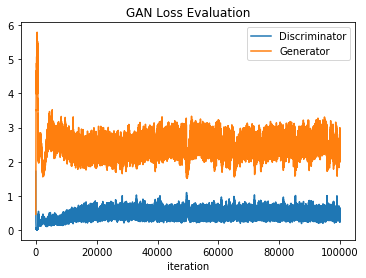

In [12]:
plt.plot(D_losses)
plt.plot(G_losses)
plt.title('GAN Loss Evaluation')
plt.ylabel('')
plt.xlabel('iteration')
plt.legend(['Discriminator', 'Generator'],loc='upper right')
plt.show()